# Initial clustering approach

This notebook demonstrates how clustering of feature vectors can be used to help improve posterior inference in basket trials.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import numpy as np
import pandas as pd
import arviz as az

In [4]:
from pyBasket.env import Trial, TrueResponseSiteWithFeatures
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF

In [5]:
DEBUG = True

In [6]:
num_burn_in = 1E5
num_posterior_samples = 1E5
num_chains = None # let pymc decide

In [7]:
if DEBUG:
    num_burn_in = 5E4
    num_posterior_samples = 5E4
    num_chains = 1

### Generate data

Similar set-up to CBHM paper.

In [18]:
K = 6    # the number of groups
p0 = 0.20 # null response rate
p1 = 0.40 # target response rate

true_response_rates = [p0, p0, p0, p1, p1, p1]
enrollment = [10, 10]

n = 100
dim = 8
pvals_map = {
    p0: [1/10] * dim,
    p1: ([0.05] * int(dim/2)) + ([0.15] * int(dim/2))
}

sites = []
for k in range(K):
    true_response_rate = true_response_rates[k]
    pvals = pvals_map[true_response_rate]
    site = TrueResponseSiteWithFeatures(k, true_response_rate, enrollment, n, pvals)
    sites.append(site)

evaluate_interim = [True, True] # evaluate every interim stage
analysis_names = ['independent', 'hierarchical', 'bhm']

In [19]:
pd1a = sites[0].enroll()
pd1a

PatientData:
responses [0 1 0 0 0 1 0 0 0 1]
features
[[10 11 14  7  3  8 13 34]
 [11  9  9 15 11 13 10 22]
 [11  5  7  8  9 12 10 38]
 [14  9  8 10 11  8 11 29]
 [ 7 13 13 13  8  9 14 23]
 [10  7 10  9 13 11 10 30]
 [10 11 10  8 10 14 11 26]
 [ 7 12 10 12 13  6 11 29]
 [11  8  9 13  9 12  9 29]
 [14  6  9  6 12 13  9 31]]

In [20]:
pd2 = sites[-1].enroll()
pd2

PatientData:
responses [0 0 1 1 1 0 0 0 1 1]
features
[[11  3  5  6 17 14 11 33]
 [ 3  4  5  2 17 21 19 29]
 [ 3  4  3  5 22 17 12 34]
 [ 8  6  5  3  8 23 18 29]
 [ 5  3  6  4 19 14 15 34]
 [ 6  8  5  3 14 11 21 32]
 [ 1  8  5  4 14 18 15 35]
 [ 3  5  4  7 16 25 13 27]
 [10  4  6  2 10 18  9 41]
 [ 6  7  4  5 17 13 17 31]]

In [21]:
futility_cutoff = DEFAULT_FUTILITY_CUTOFF
efficacy_cutoff = DEFAULT_EFFICACY_CUTOFF
early_futility_stop = True
early_efficacy_stop = False

In [22]:
trial = Trial(K, p0, p1, sites, evaluate_interim, 
              num_burn_in, num_posterior_samples, analysis_names, 
              futility_cutoff=futility_cutoff, efficacy_cutoff=efficacy_cutoff,
              early_futility_stop=early_futility_stop,
              early_efficacy_stop=early_efficacy_stop,              
              num_chains=num_chains)

In [23]:
# done = trial.reset()
# while not done:
#     done = trial.step()

In [24]:
done = trial.reset()

In [25]:
self = trial

In [26]:
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF, DEFAULT_NUM_CHAINS, \
    GROUP_STATUS_OPEN, DEFAULT_EARLY_FUTILITY_STOP, DEFAULT_EARLY_EFFICACY_STOP, \
    GROUP_STATUS_EARLY_STOP_FUTILE, GROUP_STATUS_EARLY_STOP_EFFECTIVE, \
    GROUP_STATUS_COMPLETED_EFFECTIVE, GROUP_STATUS_COMPLETED_INEFFECTIVE

In [27]:
for k in range(self.K):
    site = self.sites[k]
    patient_data = site.enroll()

    # register new patients to the right group in each model
    for analysis_name in self.analysis_names:
        model = self.analyses[analysis_name]
        group = model.groups[k]
        if group.status == GROUP_STATUS_OPEN:
            group.register(patient_data)
        print('Analysis', analysis_name, group)
    print()


Analysis independent Group 0 (OPEN): 1/10
Analysis hierarchical Group 0 (OPEN): 1/10
Analysis bhm Group 0 (OPEN): 1/10

Analysis independent Group 1 (OPEN): 1/10
Analysis hierarchical Group 1 (OPEN): 1/10
Analysis bhm Group 1 (OPEN): 1/10

Analysis independent Group 2 (OPEN): 3/10
Analysis hierarchical Group 2 (OPEN): 3/10
Analysis bhm Group 2 (OPEN): 3/10

Analysis independent Group 3 (OPEN): 3/10
Analysis hierarchical Group 3 (OPEN): 3/10
Analysis bhm Group 3 (OPEN): 3/10

Analysis independent Group 4 (OPEN): 4/10
Analysis hierarchical Group 4 (OPEN): 4/10
Analysis bhm Group 4 (OPEN): 4/10

Analysis independent Group 5 (OPEN): 5/10
Analysis hierarchical Group 5 (OPEN): 5/10
Analysis bhm Group 5 (OPEN): 5/10



Generate feature matrix for 60 patients (10 each in 6 baskets)

In [37]:
all_features = []
all_classes = []
for group in model.groups:
    features = group.features
    all_features.append(features)   
    
    N = group.features.shape[0]
    group_class = [group.idx] * N
    all_classes.extend(group_class)
    
all_features = np.concatenate(all_features)
all_classes = np.array(all_classes)
all_features.shape, all_features, all_classes.shape, all_classes

((60, 8),
 array([[11,  9, 13,  9, 13, 15, 11, 19],
        [ 7, 11, 13, 11, 11,  7,  7, 33],
        [19,  7,  6,  9,  6,  8,  7, 38],
        [11, 13,  8, 11,  6, 13, 10, 28],
        [ 6, 12, 11,  8,  8, 15,  8, 32],
        [ 7, 10, 20, 11,  9, 10,  4, 29],
        [12,  8,  8, 11,  9,  8, 15, 29],
        [ 8, 10, 14, 11, 10, 15, 10, 22],
        [11, 11, 15, 14,  8, 11, 10, 20],
        [ 9,  8, 10, 11, 14,  9, 10, 29],
        [12, 12, 11,  6,  6, 11, 13, 29],
        [14,  9, 10, 13,  8,  8, 11, 27],
        [ 8, 17,  8, 10, 11,  7, 11, 28],
        [ 6, 12,  4,  6, 12, 11, 11, 38],
        [12, 10,  7, 11, 13, 11, 15, 21],
        [ 9,  3,  9, 10, 15, 11,  7, 36],
        [14, 12,  8, 12,  9,  8, 12, 25],
        [14,  5, 11,  7, 12, 11,  6, 34],
        [ 9,  9, 13, 11, 14,  7,  9, 28],
        [ 8,  6, 11,  9,  7,  6, 14, 39],
        [ 9, 10,  9,  7, 12,  9, 15, 29],
        [15,  9,  7,  3,  9, 14, 10, 33],
        [ 7, 10, 14, 10,  8,  9,  9, 33],
        [ 6, 10, 13,  5,

PCA shows 2 clusters

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pcs = pca.fit_transform(all_features)
pca.explained_variance_ratio_.cumsum()

array([0.44511785, 0.67771532, 0.78325349, 0.86954752, 0.92197453])

<AxesSubplot: >

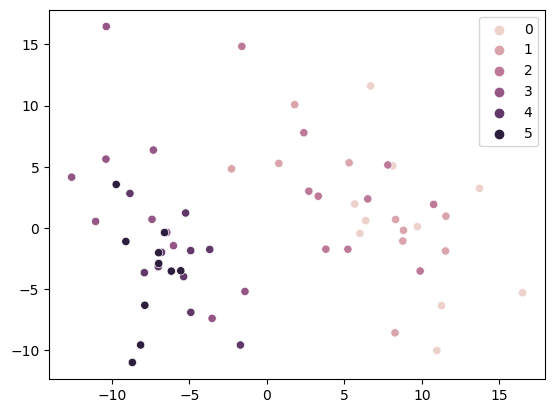

In [31]:
import seaborn as sns
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values, hue=all_classes)

Compute distance matrix

In [32]:
import numpy as np
from scipy.cluster.hierarchy import fclusterdata

# a custom function that just computes Euclidean distance
def mydist(p1, p2, c1, c2):
    if c1 == c2:
        return 0
    diff = p1 - p2
    return np.vdot(diff, diff) ** 0.5

N = all_features.shape[0]
dist = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        p1 = all_features[i]
        p2 = all_features[j]
        c1 = all_classes[i]
        c2 = all_classes[j]
        dist[i, j] = mydist(p1, p2, c1, c2)

In [33]:
import pylab as plt

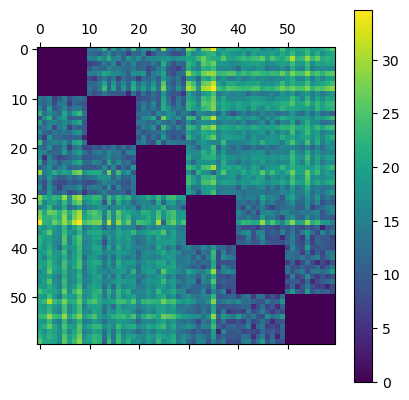

In [34]:
plt.matshow(dist)
plt.colorbar()

Hierarchical clustering

In [35]:
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as shc

condensed_dist = squareform(dist)
Z = shc.linkage(condensed_dist, method='ward')

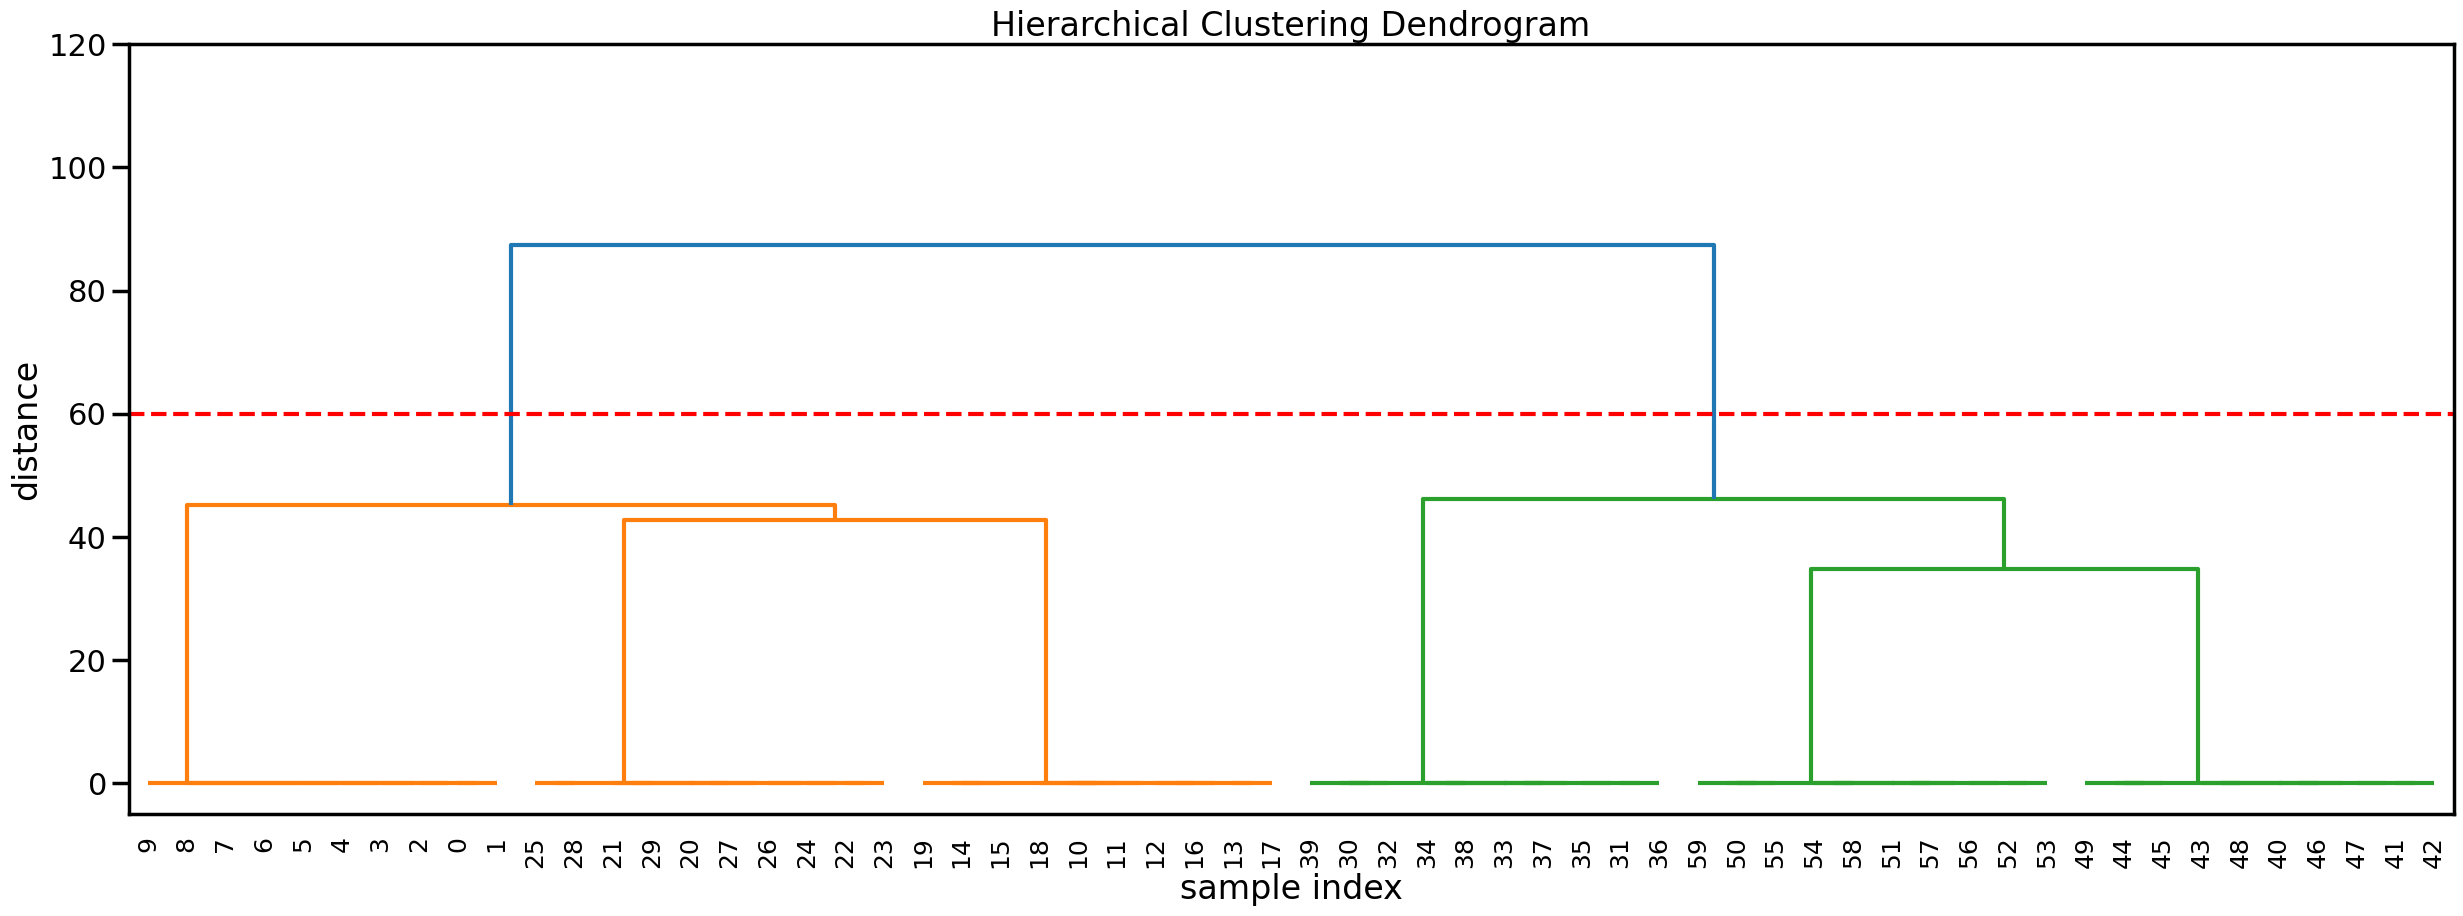

In [36]:
sns.set_context('poster')
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
shc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18,  # font size for the x axis labels
)
plt.ylim([-5, 120])
plt.axhline(y = 60, color = 'r', linestyle = '--')
plt.show()

In [38]:
from scipy.cluster.hierarchy import fcluster

max_d = 60
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Try DBScan

### Check last results

### Independent

In [ ]:
analysis_name = analysis_names[0]
analysis_name

In [ ]:
trial.visualise_model(analysis_name)

In [ ]:
trial.plot_trace(analysis_name, -1)

In [ ]:
trial.plot_posterior(analysis_name, -1)

In [ ]:
trial.final_report(analysis_name)

### Hierarchical

In [ ]:
analysis_name = analysis_names[1]
analysis_name

In [ ]:
trial.visualise_model(analysis_name)

In [ ]:
trial.plot_trace(analysis_name, -1)

In [ ]:
trial.plot_posterior(analysis_name, -1)

In [ ]:
trial.final_report(analysis_name)

### BHM

In [ ]:
analysis_name = analysis_names[2]
analysis_name

In [ ]:
trial.visualise_model(analysis_name)

In [ ]:
trial.plot_trace(analysis_name, -1)

In [ ]:
trial.plot_posterior(analysis_name, -1)

In [ ]:
trial.final_report(analysis_name)